In [72]:
import jax.numpy as jnp
import jax
from functools import partial
from jax import random
import flax
import flax.linen as nn
from flax.training.train_state import TrainState
from flax.core.frozen_dict import FrozenDict
import optax
import matplotlib.pyplot as plt

In [73]:
# class MAMLTrainState(TrainState):
#     inner_tx: optax.GradientTransformation
#     inner_params: FrozenDict

def params_equal(params1: FrozenDict, params2: FrozenDict, atol: float = 1e-8) -> bool:
    assert params1.keys() == params2.keys(), f"Keys not equal,\np1: {params1.keys()}\np2: {params2.keys()}"
    
    for key in params1["params"].keys():
        check_params1 = params1["params"][key]["kernel"]
        check_params2 = params2["params"][key]["kernel"]

        assert not jnp.array_equal(check_params1, check_params2), f"Params equal: \np1: {check_params1}\np2: {check_params2}"

In [74]:
# rng = random.PRNGKey(0)

# class Net(nn.Module):
#     n_output: int
#     n_hidden: int

#     @nn.compact
#     def __call__(self, x):
#         x = nn.relu( nn.Dense(self.n_hidden)(x) )
#         x = nn.relu( nn.Dense(self.n_hidden)(x) )
#         x = nn.Dense(self.n_output)(x)
#         return x
    
# def loss_fn(params, inputs, targets, apply_fn):
#     predictions = apply_fn(params, inputs)
#     return jnp.mean((predictions - targets)**2)

# def inner_update(params, x1, y1, apply_fn, alpha=0.1):
#     grads = jax.grad(loss_fn)(params, x1, y1, apply_fn)
#     inner_sgd_fn = lambda g, state: (state - alpha*g)
#     assert params_equal(params, jax.tree.map(inner_sgd_fn, grads, params))

#     return jax.tree.map(inner_sgd_fn, grads, params)

# def maml_loss(params, x1, y1, x2, y2, apply_fn):
#     params2 = inner_update(params, x1, y1, apply_fn)
#     return loss_fn(params2, x2, y2, apply_fn)
    
# # @jax.jit
# def meta_update(model_state: TrainState, x1, y1, x2, y2):
#     loss, grads = jax.value_and_grad(maml_loss)(model_state.params, x1, x2, y1, y2, model_state.apply_fn)
#     model_state = model_state.apply_gradients(grads=grads)
#     return model_state, loss
    
# def create_state(rng, model, in_shape, learning_rate):
#     params = model.init(rng, jnp.zeros(in_shape))
#     tx = optax.adam(learning_rate)
#     return TrainState.create(apply_fn=jax.jit(model.apply), params=params, tx=tx)


In [75]:
# rng = random.PRNGKey(0)

# class Net(nn.Module):
#     n_hidden: int
#     n_output: int

#     @nn.compact
#     def __call__(self, x):
#         x = nn.relu( nn.Dense(self.n_hidden)(x) )
#         x = nn.relu( nn.Dense(self.n_hidden)(x) )
#         x = nn.Dense(self.n_output)(x)
#         return x

# def loss_fn(params, inputs, targets, apply_fn):
#     predictions = apply_fn(params, inputs)
#     return jnp.mean((predictions - targets)**2)

# def inner_update(params, x1, y1, apply_fn):
    
#     def loss_fn(params):
#         predictions = apply_fn(params, x1)
#         return jnp.mean((predictions - y1)**2)
   
#     grads, inner_loss = jax.value_and_grad(loss_fn)(params)
#     model_inner_state = model_inner_state.apply_gradients(grads=grads)
#     return model_inner_state, inner_loss
#     # inner_sgd_fn = lambda g, state: (state - alpha*g)
#     # return jax.tree.map(partial(inner_sgd_fn, grads), params)

    
# @jax.jit
# def meta_update(model_state: TrainState, x1, y1, x2, y2):

#     def maml_loss(params, x1, y1, x2, y2):
#         params2, inner_loss = inner_update(params, x1, y1, model_state.apply_fn) 
#         # Would be simpler to just use model_state for everything
#         return loss_fn(params2, x2, y2, model_state.apply_fn)

#     loss, grads = jax.value_and_grad(maml_loss)(model_state.params, x1, y1, x2, y2)
#     model_state = model_state.apply_gradients(grads=grads)
#     return model_state, loss

# def create_state(rng, model, in_shape, learning_rate):
#     params = model.init(rng, jnp.zeros(in_shape))
#     tx = optax.adam(learning_rate)
#     inner_tx = optax.sgd(learning_rate)
#     return TrainState.create(apply_fn=jax.jit(model.apply), params=params, tx=tx)


In [76]:
g = lambda x, y : jnp.square(x) + y
x0 = 2.
y0 = 1.
print(f'grad(g)(x0) = {jax.grad(g)(x0, y0)}')
print(f'x0 - grad(g)(x0) = {x0 - jax.grad(g)(x0, y0)}')

def maml_objective(x, y):
    return g(x - jax.grad(g)(x, y), y)

print(f'maml_objective(x,y)={maml_objective(x0, y0)}')
print(f'x0 - maml_objective(x,y) = {x0 - jax.grad(maml_objective)(x0,y0)}')

grad(g)(x0) = 4.0
x0 - grad(g)(x0) = -2.0
maml_objective(x,y)=5.0
x0 - maml_objective(x,y) = -2.0


In [77]:
rng = random.PRNGKey(0)

class Net(nn.Module):
    n_hidden: int
    n_output: int

    @nn.compact
    def __call__(self, x):
        x = nn.tanh( nn.Dense(self.n_hidden)(x) )
        x = nn.tanh( nn.Dense(self.n_hidden)(x) )
        x = nn.Dense(self.n_output)(x)
        return x
        
def loss_fn(params, inputs, targets, model_inner_state):
    # print(type(params), type(model_inner_state), type(inputs), type(targets))
    predictions = model_inner_state.apply_fn(params, inputs)
    return jnp.mean((predictions - targets)**2)

def inner_update(params, x1, y1, model_inner_state):
    grads = jax.grad(loss_fn)(params, x1, y1, model_inner_state)
    # inner_sgd_fn = lambda g, state: (state - alpha*g)
    # updates, inner_opt_state = inner_opt.update(grads, inner_opt_state, params)
    # new_params = optax.apply_updates(params, updates)
    new_params = model_inner_state.apply_gradients(grads=grads)
    # params_equal(params, new_params.params, params)
    return new_params
    # return jax.tree.map(inner_sgd_fn, grads, params)

def maml_loss(params, x1, y1, x2, y2, model_inner_state):
    new_model_inner_state = inner_update(params, x1, y1, model_inner_state)
    return loss_fn(new_model_inner_state.params, x2, y2, model_inner_state)

@jax.jit
def meta_update(model_outer_state: TrainState, model_inner_state: TrainState, x1, y1, x2, y2):
    loss, grads = jax.value_and_grad(maml_loss)(model_outer_state.params, x1, x2, y1, y2, model_inner_state)
    model_outer_state = model_outer_state.apply_gradients(grads=grads)
    return model_outer_state, loss

# @partial(jax.jit, static_argnames=["model", "in_shape"])
def create_state(rng, model, in_shape, learning_rate, params=None):
    if params == None:
        params = model.init(rng, jnp.zeros(in_shape))

    tx = optax.sgd(learning_rate)
    return TrainState.create(apply_fn=jax.jit(model.apply), params=params, tx=tx)


In [78]:
rng, key = random.split(rng)
in_shape = (1,1)
outer_lr = 8e-4 # WAS 1e-3
inner_lr = 0.01
model = Net(n_hidden=32, n_output=1)
model_outer_state = create_state(key, model, in_shape, outer_lr)
model_inner_state = create_state(key, model, in_shape, inner_lr)


In [79]:
K=20
maml_losses = []
# inner_opt = optax.sgd(learning_rate=inner_lr)
# Adam optimization
import time

for i in range(30_000):
    # define the task
    rng, key1, key2, key3, key4 = random.split(rng, 5)
    A = random.uniform(key1, minval=0.1, maxval=0.5)
    phase = random.uniform(key2, minval=0., maxval=jnp.pi)
    # Meta training inner split (K examples)
    x1 = random.uniform(key3, minval=-5.0, maxval=5.0, shape=(K, 1))
    y1 = A * jnp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating wrt one example
    x2 = random.uniform(key4, minval=-5.0, maxval=5.0)
    y2 = A * jnp.sin(x2 + phase)
    x2 = jnp.expand_dims(x2, axis=0)

    model_inner_state.replace(params=model_outer_state.params)
    
    model_outer_state, loss = meta_update(model_outer_state, model_inner_state, x1, y1, x2, y2)
    assert not jnp.isnan(loss), f"loss is: {loss}"
    maml_losses.append(loss)
    if i % 1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


[Array(0.00464645, dtype=float32), Array(0.00844028, dtype=float32), Array(0.20402212, dtype=float32), Array(0.04893776, dtype=float32), Array(0.08046215, dtype=float32)]


(0.0, 1.0)

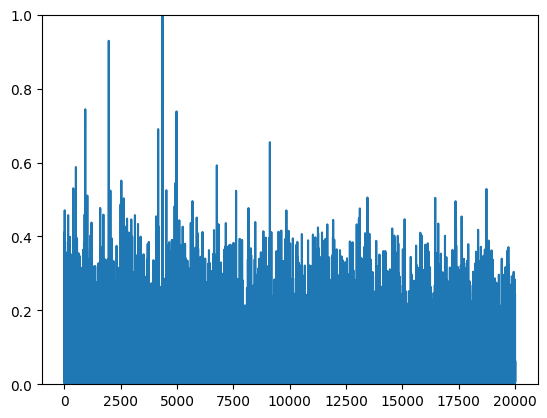

In [ ]:
# print(maml_losses[:5])
plt.plot(maml_losses)
plt.ylim(0., 1)

1-shot prediction loss: 0.705045759677887
2-shot prediction loss: 0.5944240689277649
3-shot prediction loss: 0.5414785742759705
4-shot prediction loss: 0.5133229494094849


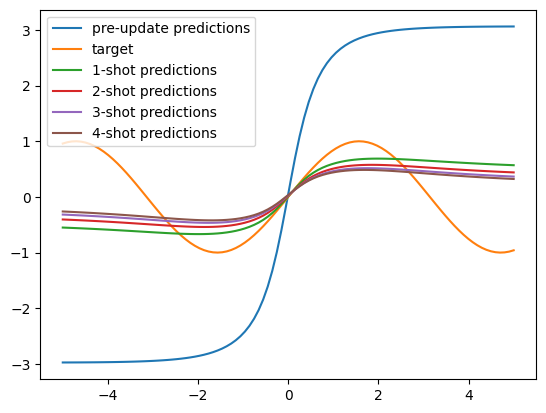

In [ ]:
xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
targets = jnp.sin(xrange_inputs)
predictions = model_outer_state.apply_fn(model_outer_state.params, xrange_inputs)
#predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

rng, key = random.split(rng)
x1 = random.uniform(key, minval=-5.0, maxval=5.0, shape=(K,1))
y1 = 1.0 * jnp.sin(x1 + 0.)

model_inner_state.replace(params=model_outer_state.params)

for i in range(1,5):
    model_inner_state = inner_update(model_inner_state.params, x1, y1, model_inner_state)
    predictions = model_inner_state.apply_fn(model_inner_state.params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label=f'{i}-shot predictions')
    print(f"{i}-shot prediction loss: {jnp.mean((predictions - targets)**2)}")
plt.legend()

In [ ]:
def sample_tasks(outter_batch_size, inner_batch_size, rng):
    As = []
    phases = []
    for _ in range(outter_batch_size):
        rng, key1, key2 = random.split(rng, 3)
        As.append(random.uniform(key1, minval=0.1, maxval=0.5))
        phases.append(random.uniform(key2, minval=0., maxval=jnp.pi))

        def get_batch(rng):
            xs, ys = [], []
            for A, phase in zip(As, phases):
                rng, key = random.split(rng, 2)
                x = random.uniform(key, minval=-5.0, maxval=5.0, shape=(inner_batch_size, 1))
                y = A * jnp.sin(x + phase)
                xs.append(x)
                ys.append(y)
            return jnp.stack(xs), jnp.stack(ys)
    
    key1, key2 = random.split(rng)
    x1, y1 = get_batch(key1)
    x2, y2 = get_batch(key2)
    return x1, y1, x2, y2

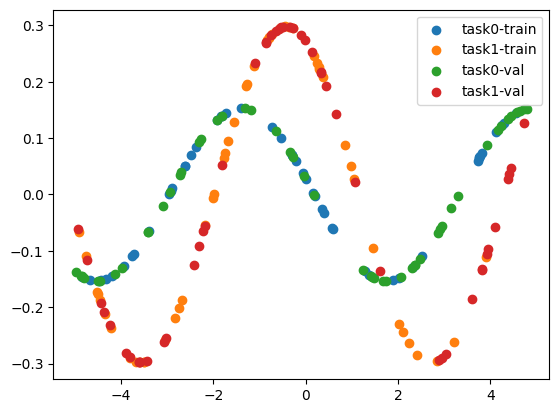

In [ ]:
outer_batch_size = 2
rng, key = random.split(rng)
x1, y1, x2, y2 = sample_tasks(outer_batch_size, 50, key)
for i in range(outer_batch_size):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(outer_batch_size):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [ ]:
rng, key1 = random.split(rng)
in_shape = (1,1)
# lr = 0.0004
del model_state
model_state = create_state(key1, model, in_shape, lr)

batched_maml_losses = []
K = 20

for i in range(20_000):
    rng, key2 = random.split(rng)
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K, key2)
    model_state, loss = meta_update(model_state, x1_b, y1_b, x2_b, y2_b, inner_opt_state, inner_opt)
    batched_maml_losses.append(loss)

    if i % 1000 == 0:
        print(i)

NameError: name 'model_state' is not defined

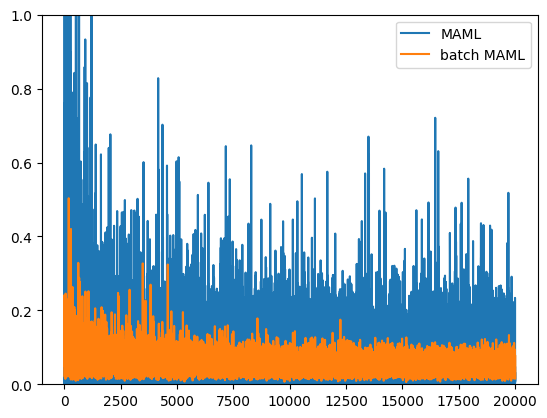

In [ ]:
plt.plot(maml_losses, label="MAML")
plt.plot(batched_maml_losses, label="batch MAML")
plt.ylim(0., 1)
plt.legend()

1-shot prediction loss: 0.6578805446624756
2-shot prediction loss: 0.5896470546722412
3-shot prediction loss: 0.5952205657958984
4-shot prediction loss: 0.5795696973800659


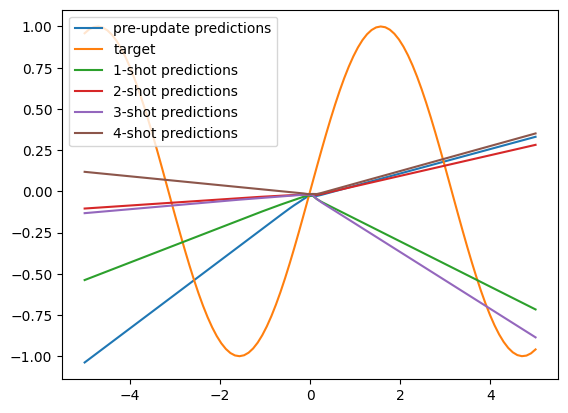

In [ ]:
xrange_inputs = jnp.linspace(-5,5,100).reshape((100,1))
targets = jnp.sin(xrange_inputs)
predictions = model_state.apply_fn(model_state.params, xrange_inputs)
#predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

rng, key = random.split(rng)
x1 = random.uniform(key, minval=-5.0, maxval=5.0, shape=(K,1))
y1 = 1.0 * jnp.sin(x1 + 0.)

net_params = model_state.params

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1, model_state, inner_opt_state, inner_opt)
    predictions = model_state.apply_fn(net_params, xrange_inputs)
    plt.plot(xrange_inputs, predictions, label=f'{i}-shot predictions')
    print(f"{i}-shot prediction loss: {jnp.mean((predictions - targets)**2)}")

plt.legend()